# Проект SF TripAdvisor Rating - прогнозирование рейтинга ресторана на TripAdvisor.
**Автор - Михаил Пустовалов**
Версия 2, с расширенными данными, от 24 ноября 2020.
EDA в этой версии сокращён, потому что по сути он был проделан в 1 версии.\

Более того, данные подготовлены очень небрежно, поскольку целбь ЭТОЙ версии - научиться утягивать данные с сайтов и посмотреть, 
что будет, если предоставить в модель больше данных.
Даже при такой небрежной подготовке MAE = 0.1371664500344063, что гораздо лучше лучшего моего решения на условиях соревнования.

# 0. Импорты.

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import collections
from pprint import *
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import os
import seaborn as sns
%matplotlib inline
#Make sure that input files are in place
for dirname, _, filenames in os.walk('./inputs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./inputs/dataset.csv


Прочие настройки

In [221]:
#настройки графиков
sns.set(rc={'figure.figsize':(20,7)}, style = 'whitegrid', palette = 'tab10')
#зафиксируем random seed
RANDOM_SEED = 42
#pip freeze
!pip freeze > ./outputs/requirements.txt

In [222]:
def get_col_summary_binary(column):
    print(f'Ресторанов с отметкой {column} = 1:', data.query(f'{column} == 1')[column].shape[0])
    print(f'Ресторанов с незаполненной отметкой {column}:', data[column].isnull().sum())
    print(f'Уникальные значения: {list(data[column].unique())}')

# 1. Загрузка и осмотр данных.

Загрузим данные и посмотрим на них.

In [223]:
DATA_DIR = './inputs/'
OUTPUT_DIR = './outputs/'
data = pd.read_csv(DATA_DIR + 'dataset.csv')

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103441 entries, 0 to 103440
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID_TA            102949 non-null  object 
 1   name             102885 non-null  object 
 2   closed           102885 non-null  float64
 3   inactive         103441 non-null  int64  
 4   name_changed     103441 non-null  int64  
 5   rating           103375 non-null  object 
 6   claimed          102862 non-null  float64
 7   primary_cus      102949 non-null  object 
 8   city             98253 non-null   object 
 9   cuisines         64331 non-null   object 
 10  special_diets    14954 non-null   object 
 11  pricing          45345 non-null   object 
 12  rank             88792 non-null   float64
 13  city_rest_count  88792 non-null   float64
 14  is_website       102949 non-null  float64
 15  photo_count      102949 non-null  float64
 16  is_video         102949 non-null  floa

В трейне у нас 103441 записей, и в них есть пропуски.

In [225]:
data.head(5)

,ID_TA,name,closed,inactive,name_changed,rating,claimed,primary_cus,city,cuisines,...,cus_rest_count,address,mail,tel,review_number,reviews,review_dates,review_ratings,orig_url,URL_TA
0,d9328394,Pizza School,0.0,0,0,4.0,0.0,Unknown,Seoul,NaN,...,NaN,"224, World Cup Buk-Ro, Seoul South Korea",0.0,+82 2-372-1988,1,NaN,"February 7, 2017",NaN,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
1,d9337164,Pujimi Tripes,0.0,0,0,4.5,0.0,Unknown,Seoul,NaN,...,NaN,"23, cheonhoyet14-Gil, Seoul South Korea",0.0,NaN,3,NaN,"November 12, 2019 ,February 4, 2019 ,March 27,...",NaN,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
2,d8956216,Bangung,0.0,0,0,4.5,0.0,Unknown,Seoul,NaN,...,NaN,"17, Gangseo-ro56-Gil, Seoul South Korea",0.0,NaN,5,NaN,"February 26, 2020 ,January 15, 2020 ,September...",NaN,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
3,d9335213,Donsoobaek - Gangnam Station Direct Store,0.0,0,0,4.5,0.0,Asian,Seoul,"Asian, Korean",...,3565.0,"13, Gangnam-daero 110-gil, Gangnam-gu, Seoul 0...",0.0,+82 2-539-3132,7,"Nothing special, but the stew is neat and the ...","February 1, 2018",NaN,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...
4,d9334370,Pork Mo U,0.0,0,0,4.0,0.0,Unknown,Seoul,NaN,...,NaN,"26, Nohae-ro69-Gil, Seoul South Korea",0.0,NaN,1,NaN,"October 27, 2017",NaN,https://www.tripadvisor.com/Restaurant_Review-...,https://www.tripadvisor.com/Restaurant_Review-...


Для начала выкинем рестораны с неактивными ресторанами, потом столбец с данными об активности и сразу поставим индекс на ID_TA.

Признаки будем очищать и причёсывать.

In [226]:
data.drop(index = data.query('inactive == 1').index,
          inplace = True)
data.drop(columns = 'inactive', inplace = True)
data.set_index('ID_TA', inplace = True)

## 2. Очистка и подготовка данных.
Пойдём немного по другому маршруту, нежели предложен в базовом решении. Каждый признак мы посмотрим сначала отдельно, заполним NaN, удалим дубликаты, погенеруем очевидные новые признаки.
Столбцы, которые у нас есть:

## 2.0. Rating - целевая переменная

In [227]:
print(f'Ресторанов с незаполненным рейтингом: {data["rating"].isnull().sum()}')
print(f'Уникальные значения: {list(data.rating.unique())}')

Ресторанов с незаполненным рейтингом: 64
Уникальные значения: ['4.0', '4.5', '2.0', '3.5', '5.0', '2.5', '3.0', '1.0', nan, '1.5', '0.0']


Выкинем все, для которых мы не знаем целевую переменную.

In [228]:
data.dropna(subset = ['rating'], inplace = True)

Чистить и дозаполнять не надо, просто поменяем тип

In [229]:
data.loc[:, 'rating'] = data.rating.astype(np.float32)

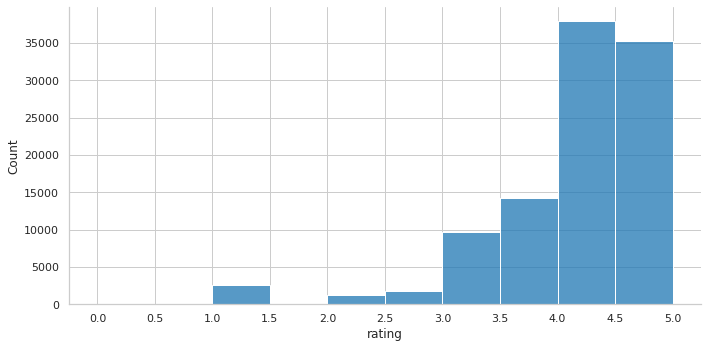

In [230]:
rat = sns.displot(data.rating, height = 5, aspect = 2, bins = 10)
rat.set(xticks = np.arange(0, 5.5, 0.5))

## 2.1. Name
Имена нам в этом анализе не нужны. Выбросим.

In [231]:
data.drop(columns = 'name', inplace = True)

## 2.2. Closed
Есть ли отметка "closed" на странице ресторана. Пропусков нет.

In [232]:
get_col_summary_binary('closed')

Ресторанов с отметкой closed = 1: 2536
Ресторанов с незаполненной отметкой closed: 0
Уникальные значения: [0.0, 1.0]


In [233]:
data.loc[:, 'closed'] = data['closed'].astype(np.int8)

Особо больше нечего сказать по этому столбцу. Перекодировать уже ничего не надо.

## 2.3. Name changed.
Менял ли ресторан своё имя. Логика при скрейпинге была такая: если при попытке пройти по ссылке вылетает redirect, то смотрим, куда он нас привёл. Если на страницу ресторана, то он просто смнеил название, если же на страницу "не ресторана" (обычно если страницы ресторана нет, то выдаётся страница со списком ресторанов на местности или просто 404), то он больше неактивен, страницы нет.

In [234]:
get_col_summary_binary('name_changed')

Ресторанов с отметкой name_changed = 1: 280
Ресторанов с незаполненной отметкой name_changed: 0
Уникальные значения: [0, 1]


In [235]:
data.loc[:, 'name_changed'] = data['name_changed'].astype(np.int8)

## 2.4. Claimed.
Есть ли отметка "claimed" на странице ресторана. NaN заполним нулями (как unclaimed).

In [236]:
get_col_summary_binary('claimed')

Ресторанов с отметкой claimed = 1: 26793
Ресторанов с незаполненной отметкой claimed: 23
Уникальные значения: [0.0, 1.0, nan]


In [237]:
data.claimed.fillna(value = 0, inplace=True)

In [238]:
data.loc[:, 'claimed'] = data['claimed'].astype(np.int8)

## 2.5. Primary cus.
"Основная" кухня, по которой считается ранкинг. Ранкингов может быть два - по основной кухне в городе, или всего по городу.

Пропусков не было. Создадим отметку, если основная кухня не указана.

In [241]:
data['no_primary_cuisine'] = data.primary_cus.apply(lambda x: 1 if x == 'Unknown' else 0)

Почти половина ресторанов не имеют заданной "главной" кухни. Не будем растаскивать на dummy, столбец, скорее, технический, он нужен для определения ранга ресторана в кухне. Сам по себе не очень нужен, выбросим его.

In [242]:
(data['primary_cus'] == 'Unknown').sum()

41653

In [243]:
data.drop(columns = 'primary_cus', inplace=True)

## 2.6. City.
Город расположения. ПРи скрейпинге мы ограничились 5 городами. Посмотрим на данные.

In [245]:
print(f'Ресторанов с незаполненной city: {data.query("city.isna()").city.shape[0]}')
print(f'Уникальные значения: {list(data.city.unique())}')

Ресторанов с незаполненной city: 4690
Уникальные значения: ['Seoul', 'Paris', 'London', nan, 'Osaka', 'Sao Paulo', 'Thornton Heath', 'Jundiai', 'Ile-de-Sein', 'Mitcham', 'Barking', 'Chuo', 'Hounslow', 'Sutton']


Некоторые города считались как отдельные районы. Перетранслируем по соответствию кода города с TA.

In [246]:
code_dict = {
    'g294197':'Seoul',
    'g298566':'Osaka',
    'g186338':'London',
    'g303631':'Sao Paulo',
    'g187147':'Paris'
}
data['city_code']= data.apply(lambda x: re.search('g\d+', x.URL_TA)[0], axis = 1)
data['city'] = data.apply(lambda x: code_dict[x.city_code], axis = 1)

In [247]:
print(f'Уникальные значения: {list(data.city.unique())}')

Уникальные значения: ['Seoul', 'Paris', 'London', 'Osaka', 'Sao Paulo']


Вот теперь нормально. Сгенерируем dummies по городу, сам столбец с городами пока оставим - ещё будут нужны для нормировки рангов по городам.

In [248]:
data = pd.merge(data, pd.get_dummies(data['city']), 
                left_index=True, right_index=True)

## 2.7. Cuisines и special diets.
Список кухонь и список спецдиет. Воспринимаем эти данные как данные одной природы, то есть сведём в одну. Надо почистить и преобразовать в список.

In [249]:
print(f'Ресторанов с nan в кухне: {data.query("cuisines.isna()").cuisines.shape[0]}')

Ресторанов с nan в кухне: 38603


Очень много. Надо менять на Unknown. Заодно создадим признак "не указаны кухни"

In [250]:
data.loc[data.query("cuisines.isna()").index, 'cuisines'] = 'Unknown'
data['no_cuisines'] = data.cuisines.apply(lambda x: 1 if 'Unknown' in x else 0)

In [251]:
data.loc[:, 'cuisines'] = data.cuisines.apply(lambda x: x.split(', '))

In [252]:
print(f'Ресторанов с nan в special_diets: {data.query("special_diets.isna()").special_diets.shape[0]}')

Ресторанов с nan в special_diets: 88059


Лишний unkown не добавляем в общий список! Заодно создадим признак "не указаны special diets".

In [253]:
data.loc[data.query("special_diets.isna()").index, 'special_diets'] = 'Unknown'
data['no_special_diets'] = data.special_diets.apply(lambda x: 1 if 'Unknown' in x else 0)
data.loc[:, 'special_diets'] = data.special_diets.apply(lambda x: x.split(', '))
data.loc[:, 'cuisines'] = data.apply(lambda x: x.cuisines + x.special_diets
                                     if x.special_diets!=['Unknown'] 
                                     else x.cuisines, axis = 1)

In [254]:
data.drop(columns = 'special_diets', inplace=True)

Посмотрим на разнообразие кухонь.

In [255]:
cus = data.explode(column = 'cuisines').reset_index()

In [256]:
cus.groupby('cuisines').count()['ID_TA'].sort_values(ascending = False)

cuisines
Unknown                38603
Vegetarian Friendly    14166
Asian                   9831
Japanese                9270
Cafe                    8997
                       ...  
Lombard                    1
Slovenian                  1
Polynesian                 1
Calabrian                  1
Yunnan                     1
Name: ID_TA, Length: 160, dtype: int64

<AxesSubplot:xlabel='cuisines'>

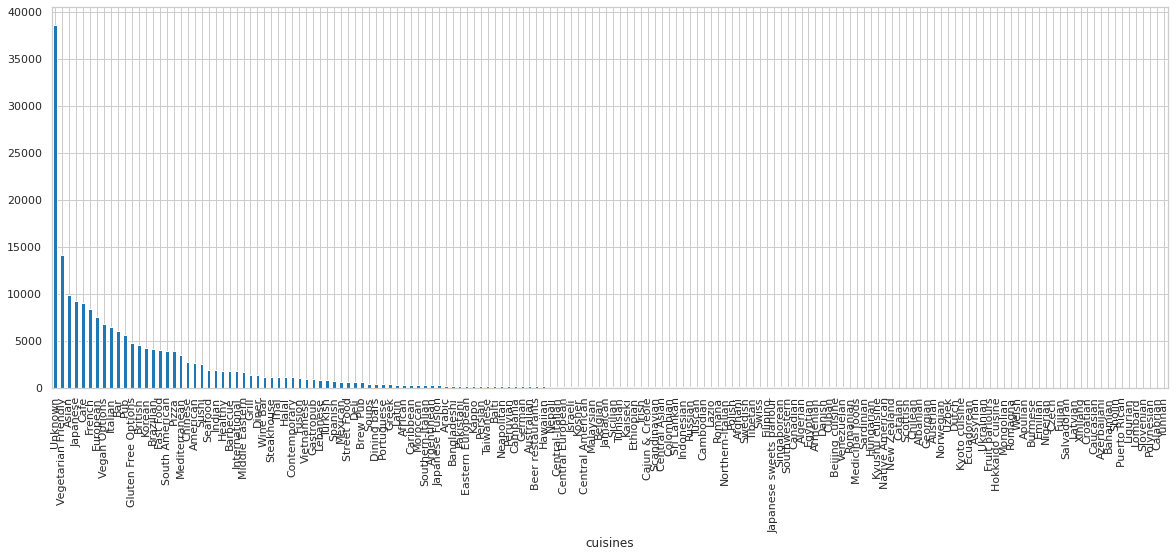

In [257]:
cus_stats = (cus.groupby('cuisines')['ID_TA'].count()
                                              .sort_values(ascending=False))
cus_stats.plot(kind = 'bar')

Unknown мешается. Уберём с графика.

<AxesSubplot:xlabel='cuisines'>

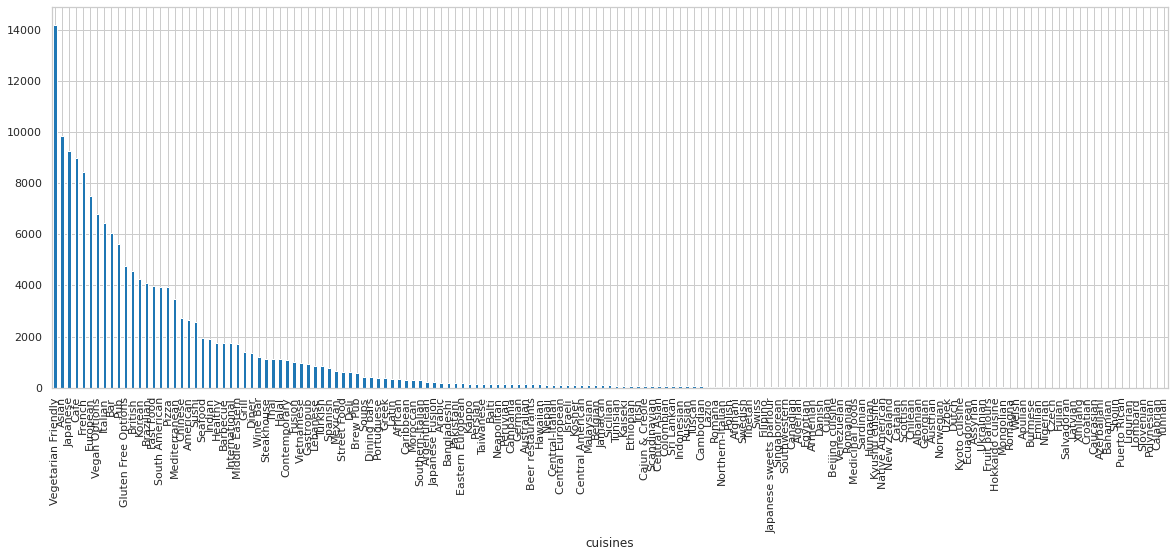

In [258]:
cus_stats[cus_stats.index!='Unknown'].plot(kind = 'bar')

Как видим, есть уникальные кухни, а есть наоборот популярные. 

Четыре идеи новых признаков - "не указана кухня (Unknown)", "есть кухня из топ-10 популярных", "есть кухня из топ-10 уникальных", "количество кухонь, представленных в ресторане'

### Признаки из cuisine style.

Создадим признак - количество кухонь в ресторане, посмотрим распределения.

<AxesSubplot:>

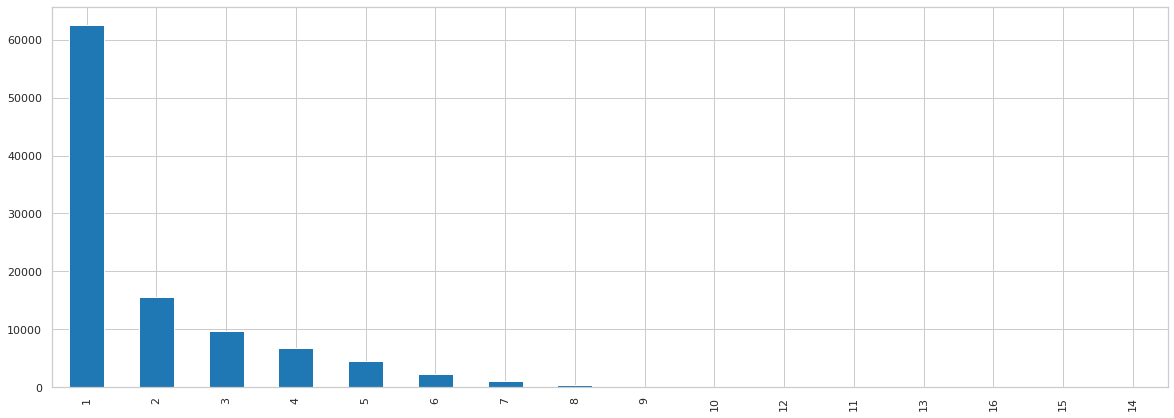

In [259]:
data['cus_num'] = data['cuisines'].apply(len)
data['cus_num'].value_counts().plot(kind = 'bar')

<AxesSubplot:xlabel='cus_num'>

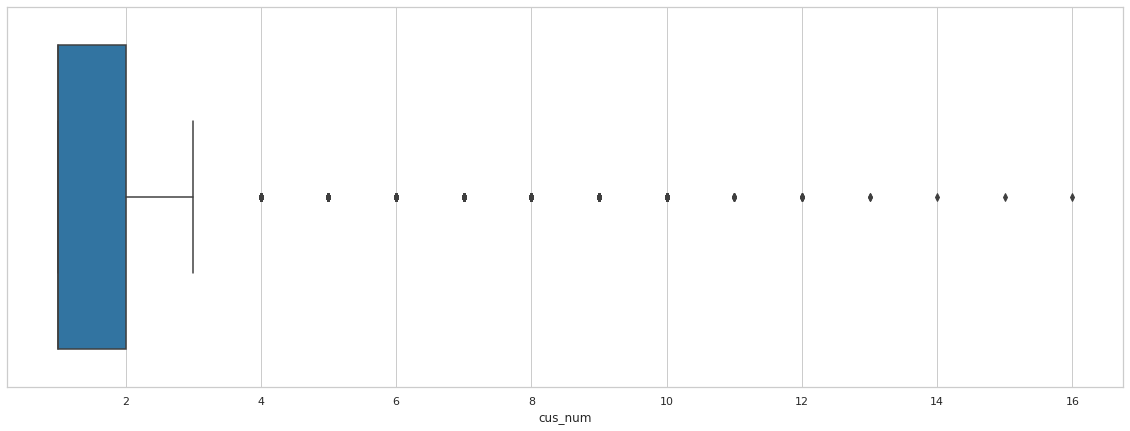

In [260]:
sns.boxplot(x = data['cus_num'])

Есть рестораны рекордсмены, где кухонь 10 и больше. EDA в первой версии блокнота показал, что это нормально.

Всё-таки мы удалим все рестораны, у которых кухонь больше 10 и нормализуем их (без центровки)

In [261]:
data.drop(data.query('cus_num > 10').index, inplace = True)
scaler = MinMaxScaler()
res = np.array(scaler.fit_transform(np.array(data['cus_num']).reshape(-1, 1)))
data['cus_num_norm'] = pd.Series(res.flatten(), data.index)

<AxesSubplot:>

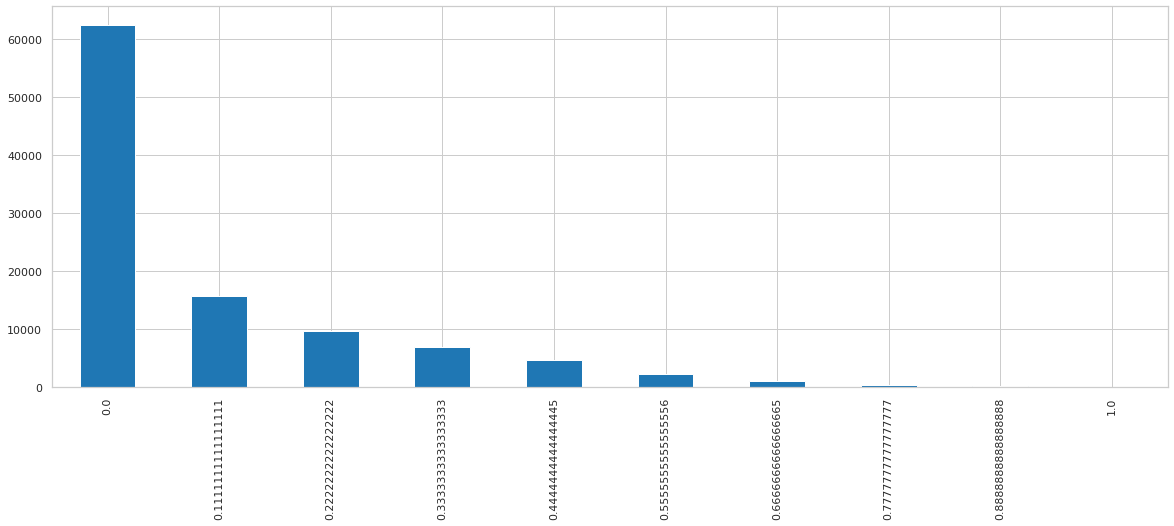

In [262]:
data.cus_num_norm.value_counts().plot(kind = 'bar')

Найдём топ 10 кухонь по популярности, Unknown исключим, и все "уникальные" - то есть 10 нижних.

In [263]:
top10 = (cus.groupby('cuisines').count()
            .sort_values(by = 'ID_TA', ascending = False)
            .query('index!="Unknown"'))[0:11]
pprint(list(top10.index))

['Vegetarian Friendly',
 'Asian',
 'Japanese',
 'Cafe',
 'French',
 'European',
 'Vegan Options',
 'Italian',
 'Bar',
 'Pub',
 'Gluten Free Options']


In [264]:
unique = (cus.groupby('cuisines').count()
             .sort_values(by = 'ID_TA', ascending = True)[0:11])
pprint(list(unique.index))

['Yunnan',
 'Calabrian',
 'Polynesian',
 'Slovenian',
 'Lombard',
 'Ligurian',
 'Puerto Rican',
 'Shojin',
 'Bahamian',
 'Azerbaijani',
 'Caucasian']


Теперь на основе этих данных создадим признаки - количество популярных кухонь в ресторане, и количество уникальных

In [265]:
data['pop_cus_count'] = data['cuisines'].apply(lambda x: len((set(x)).intersection(top10.index)))
data['unique_cus_count'] = data['cuisines'].apply(lambda x: len((set(x)).intersection(unique.index)))

## 2.8. Pricing
Уровень цен в ресторанах.

In [266]:
print(f'Число пропусков в pricing: {data.pricing.isnull().sum()}')
print(f'Число пропусков в pricing: {round(100*data.pricing.isnull().sum()/len(data),2)}%')
print(f'Уникальные значения в pricing: {data.pricing.unique()}%')

Число пропусков в pricing: 57562
Число пропусков в pricing: 55.82%
Уникальные значения в pricing: ['$$ - $$$' '$$$$' nan '$']%


Очень много пропусков... Заполним модой.

In [267]:
data['pricing'].value_counts()

$$ - $$$    31206
$           11812
$$$$         2538
Name: pricing, dtype: int64

In [268]:
data['pricing'].value_counts(normalize = True)

$$ - $$$    0.685003
$           0.259285
$$$$        0.055712
Name: pricing, dtype: float64

Очень дорогих ресторанов немного, а самые распространённые - средней ценовой категории. Заменим пропуски в pricing модой.

In [269]:
data['pricing'].mode()[0]

'$$ - $$$'

In [270]:
data.loc[data['pricing'].isnull(), 'pricing'] = data['pricing'].mode()[0]
data['pricing'].value_counts(normalize = True)

$$ - $$$    0.860839
$           0.114548
$$$$        0.024613
Name: pricing, dtype: float64

Сразу растащим на dummy.

In [271]:
data = pd.merge(data, pd.get_dummies(data['pricing']), 
                                     left_index=True, right_index=True)
data.drop(columns = 'pricing', inplace = True)

## 2.9. Rank и city_rest_count.

Ранг ресторана в городе и общее число ресторанов в городе, где располагается ресторан. Посмотрим пропуски и уникальные значения.

In [272]:
print('Количество пропусокв: ', data['rank'].isnull().sum())
print('Число уникальных рангов: ', data['rank'].nunique())

Количество пропусокв:  14346
Число уникальных рангов:  20320


Выбросов не видно.

<AxesSubplot:xlabel='rank'>

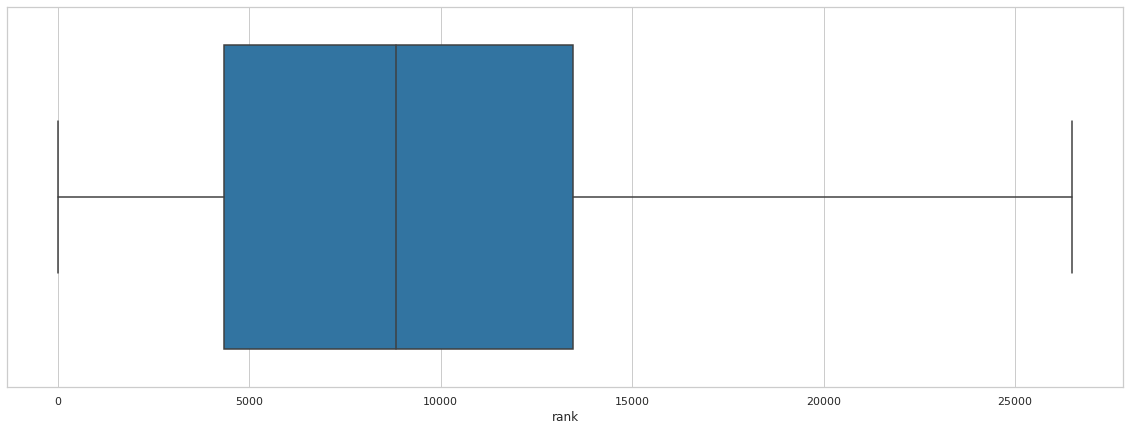

In [273]:
sns.boxplot(x = data['rank'])

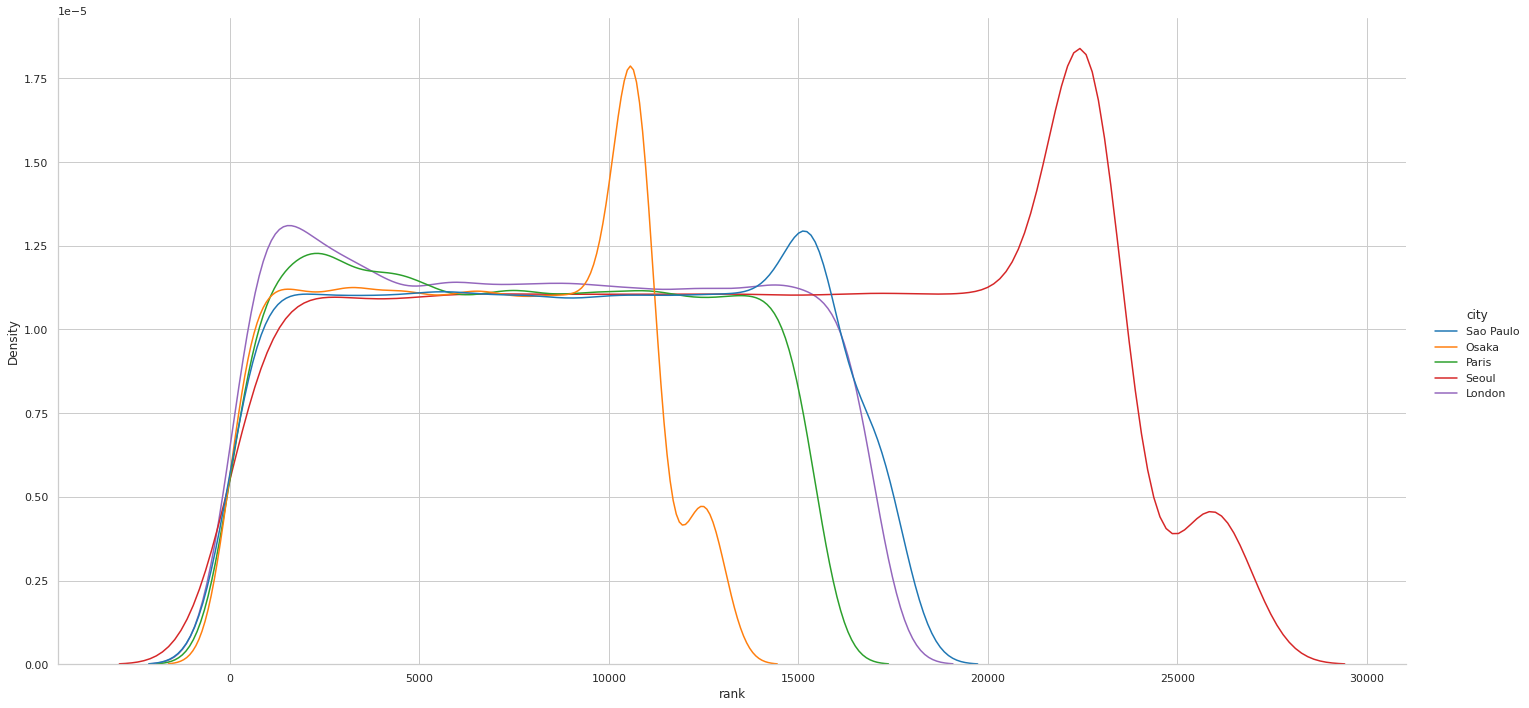

In [274]:
sns.displot(x = 'rank', data = data, hue = 'city', 
            height = 10, aspect = 2, kind = 'kde')

Странные пики... Ручная проверка нескольких ссылок показала, что это корректно утянутые данные. Действительно, многие рестораны имеют одинаковый ранг, причём это рестораны со дна. Похоже, что TA не особо заморачивается с ранжированием таких ресторанов. Так что данные корректны! Заполним пропуски медианой и нормализуем их по городу.

In [275]:
city_medians = dict(data.groupby('city')['rank'].median())
for city in city_medians.keys():
    data.loc[(data['city'] == city) & (data['rank'].isnull()), 'rank'] = city_medians[city]

In [276]:
data['norm_rank'] = -1000
for one_city in data['city'].unique():
    temp_df = data.loc[data['city'] == one_city].copy()
    scaler = StandardScaler()
    res = np.array(scaler.fit_transform(np.array(temp_df['rank']).reshape(-1, 1)))
    data.loc[data['city'] == one_city, 'norm_rank'] = pd.Series(res.flatten(), temp_df.index)

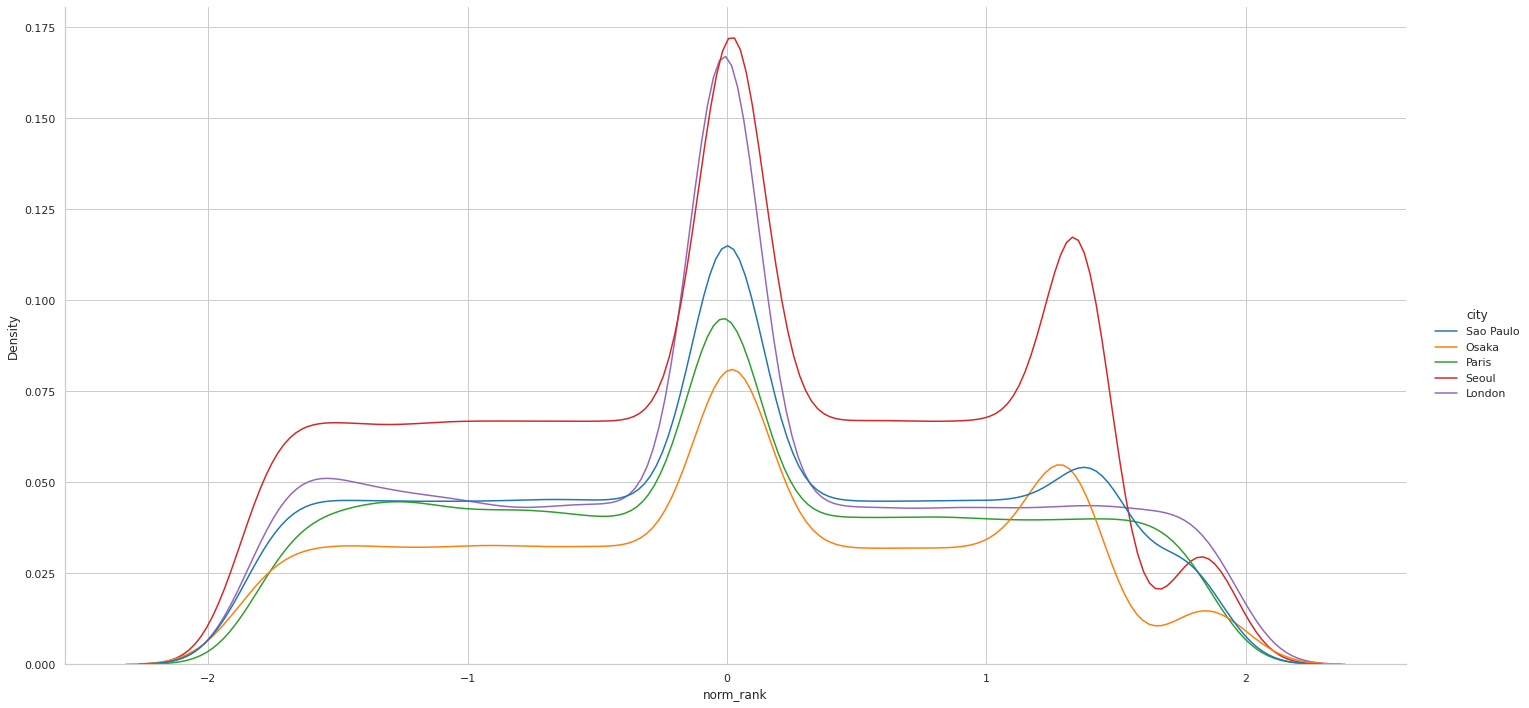

In [277]:
sns.displot(x = 'norm_rank', data = data, hue = 'city', 
            height = 10, aspect = 2, kind = 'kde')

После нормализациии признак city_rest_count оказывается не нужен.

In [278]:
data.drop(columns = 'city_rest_count', inplace = True)

## 2.10. Is_website.

Указывает, есть ли ссылка на сайт ресторана.

In [279]:
get_col_summary_binary('is_website')

Ресторанов с отметкой is_website = 1: 49811
Ресторанов с незаполненной отметкой is_website: 0
Уникальные значения: [1.0, 0.0]


In [280]:
data.is_website = data.is_website.astype(np.int8)
data.is_website.value_counts()

0    54819
1    49811
Name: is_website, dtype: int64

## 2.11. photo_count

Количество фотографий на странице ресторана.

In [281]:
print('Количество пропусокв: ', data['photo_count'].isnull().sum())
print('Число уникальных значений: ', data['photo_count'].nunique())

Количество пропусокв:  0
Число уникальных значений:  921


In [282]:
data.photo_count = data.photo_count.astype(np.int16)

Проверим корректность больших значений.

In [283]:
data.photo_count.max()

7150

In [284]:
data.query('photo_count == photo_count.max()').URL_TA.values

array(['https://www.tripadvisor.com/Restaurant_Review-g187147-d736855-Reviews-58_Tour_Eiffel_Restaurant-Paris_Ile_de_France.html'],
      dtype=object)

Ресторан на Эйфелевой башне, действительно столько фотографий. Допускаем.

## 2.12. Is_video.

Указывает, есть ли видео на странице ресторана.

In [285]:
get_col_summary_binary('is_video')

Ресторанов с отметкой is_video = 1: 731
Ресторанов с незаполненной отметкой is_video: 0
Уникальные значения: [0.0, 1.0]


In [286]:
data.is_video = data.is_video.astype(np.int8)
data.is_video.value_counts()

0    103899
1       731
Name: is_video, dtype: int64

## 2.13. Mail
Указана ли электронная почта, 1- да, 0 - нет.

In [287]:
get_col_summary_binary('mail')

Ресторанов с отметкой mail = 1: 24128
Ресторанов с незаполненной отметкой mail: 0
Уникальные значения: [1.0, 0.0]


In [288]:
data.mail = data.mail.astype(np.int8)
data.mail.value_counts()

0    80502
1    24128
Name: mail, dtype: int64

## 2.14. Tel
Телефон ресторана, если NaN - то не указан. Сам телефон нам не нужен, важен факт его наличия.

In [289]:
data.loc[data.tel.notnull(), 'tel'] = 1
data.tel.fillna(0, inplace = True)

## 2.15. Cus_rest_rank и cus_rest_count.
Ресторан может иметь два ранкинга - по городу (обработали) и по основной кухне в городе. При этом пропусков очень много - иногда просто не указана основная кухня, иногда нет ранга. Поэтму предлагается не морочиться с нормализацией, а создать переменную - относительный ранг по кухне, заполнить пропуски средним и поставить отметку.

In [290]:
print('Количество пропусокв cus_rest_rank: ', data['cus_rest_rank'].isnull().sum())
print('Количество пропусокв cus_rest_count: ', data['cus_rest_count'].isnull().sum())

Количество пропусокв cus_rest_rank:  50415
Количество пропусокв cus_rest_count:  50415


In [291]:
data['rel_cus_rank'] = data.cus_rest_rank/data.cus_rest_count

In [292]:
data['no_rel_cus_rank'] = data['rel_cus_rank'].isnull().astype(np.int8)

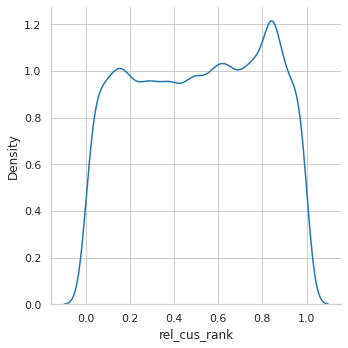

In [293]:
sns.displot(data.rel_cus_rank, kind = 'kde')

In [294]:
data.rel_cus_rank.fillna(data.rel_cus_rank.mean(), inplace = True)

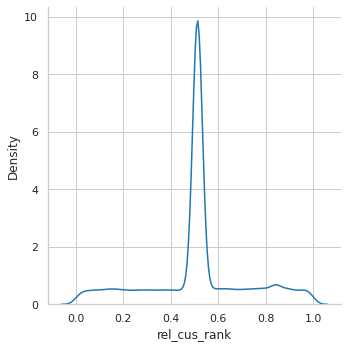

In [295]:
sns.displot(data.rel_cus_rank, kind = 'kde')

In [296]:
data.drop(columns = ['cus_rest_rank', 'cus_rest_count'], inplace = True)

## 2.16. Address
Адрес. Был взят, скорее от жадности, хотя с помощью геокодера можно из него вытащить полезную информацию, например расстояние до центра города, достопримечательностей, и т.д.

In [297]:
data.drop(columns = 'address', inplace = True)

## 2.17. Review_number
Сколько всvего отзывов есть о ресторане

In [298]:
print(f'Число пропусков в review_number: {data.review_number.isnull().sum()}')
print(f'Число пропусков в review_number: {round(100*data.review_number.isnull().sum()/len(data),2)}%')

Число пропусков в review_number: 0
Число пропусков в review_number: 0.0%


Пропусков нет. Посмотрим на выбросы.

<AxesSubplot:xlabel='review_number'>

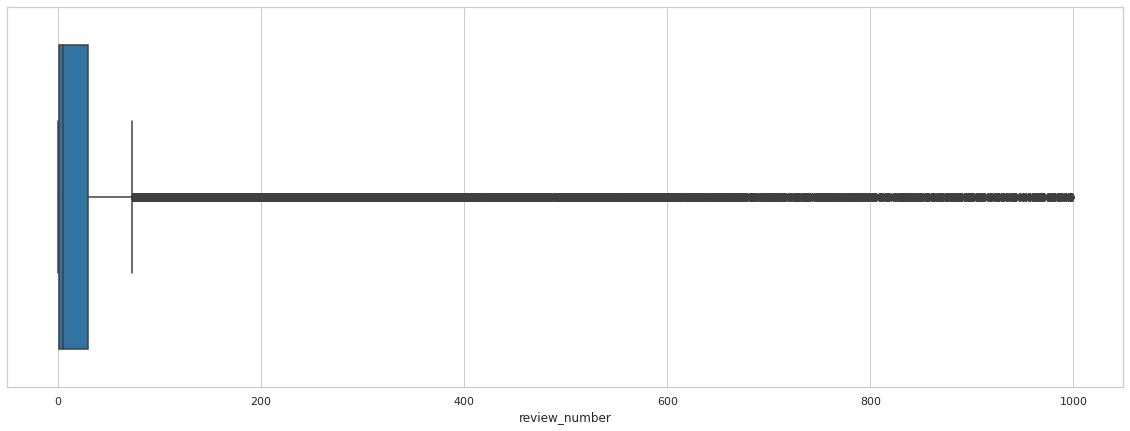

In [299]:
sns.boxplot(x = data.review_number)

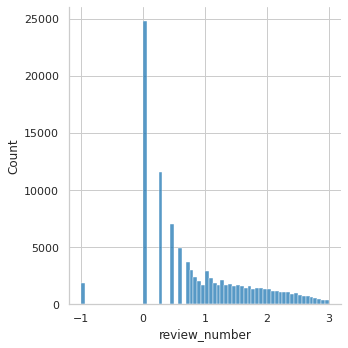

In [300]:
sns.displot(data.review_number.apply(lambda x: np.log10(x) if x!=0 else -1))

Так лучше. Значения с минус единицей - это 0 ревью.

# ОБРАБОТКА ОТЗЫВОВ ОТЛОЖЕНА НА ПОТОМ (ИЛИ НА НИКОГДА).

# 3. Модель.

Выбросим все колонки, в которых у нас объекты

In [301]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104630 entries, d10000032 to d9999972
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   closed              104630 non-null  int8   
 1   name_changed        104630 non-null  int8   
 2   rating              104630 non-null  float32
 3   claimed             104630 non-null  int8   
 4   rank                104630 non-null  float64
 5   is_website          104630 non-null  int8   
 6   photo_count         104630 non-null  int16  
 7   is_video            104630 non-null  int8   
 8   mail                104630 non-null  int8   
 9   tel                 104630 non-null  int64  
 10  review_number       104630 non-null  int64  
 11  no_primary_cuisine  104630 non-null  int64  
 12  London              104630 non-null  uint8  
 13  Osaka               104630 non-null  uint8  
 14  Paris               104630 non-null  uint8  
 15  Sao Paulo           104630 no

In [303]:
X = data.reset_index(drop = True).drop(['rating'], axis = 1)  
y = data.reset_index(drop = True)['rating'] 

In [304]:
data['rank'] = data['rank'].astype(np.float32)
data['cus_num_norm'] = data['cus_num_norm'].astype(np.float32)
data['norm_rank'] = data['norm_rank'].astype(np.float32)
data['rel_cus_rank'] = data['rel_cus_rank'].astype(np.float32)

Пока посмотрим как модель работает на трейне.

In [305]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = np.round(regr.predict(X_test)*2)/2

In [306]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1371664500344063


<AxesSubplot:>

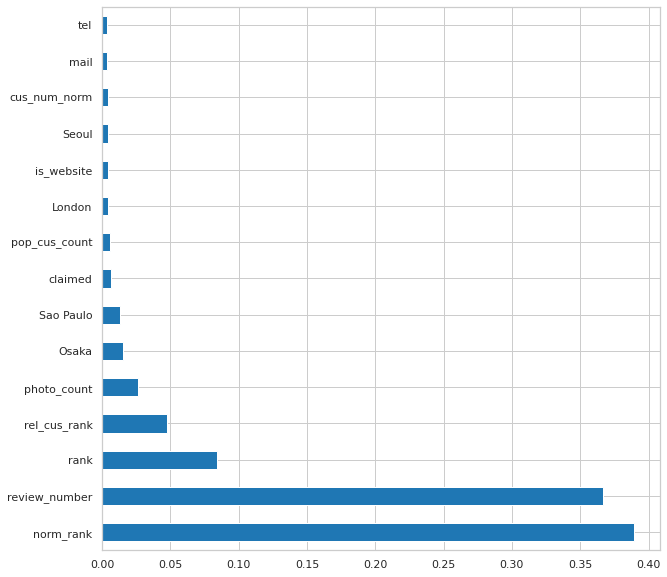

In [307]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')